## Target Hypothesis

The most optimal model is found on the data where there are 2 rows of CO applicant --> BRFE (RF)

NOW DO THIS -->

1. Score both Main & Co as two seperate customers

bs = fit(bs)

ws = fit(ws)




2. Make a model of both with Co as a dummy


bs = xtrain (bs,ws)


2.1 

    ws input 0


    if 1 Applicant:

        bs = xtrain (bs,0)

    else:

        bs = xtrain (bs,ws)


2.2  --> could be adversed selection due to that having a co applicant might say something about the relasionship between the two

    ws - applications with co -applicant and for these take the mean 


    if 1 Applicant:

        bs = xtrain (bs,mean(ws))

    else:

        bs = xtrain (bs,ws)




3. Worst 

if main = main:

else:

    ws




4. Best --makes sence     1. Main -- Always main -->  2. CO --> best score 


if main = main:

else:

    bs



5. Test two seperate scorecards for main & co

5.1 

     main = main 

     Co --> Best 

5.2

     main = main 

     Co --> CO 




In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')
#df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge','HasCoapp'])


import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_val, y_val, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    return np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])



In [2]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
# Assuming `df`, `preprocessor`, `train`, `val`, `test`, `gini_score`, and `plot_gini` are predefined




# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')

df = pd.concat([train,val,test])

In [3]:
print(len(train) + len(val) + len(test))
df

3453


,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-10-02,8409647,0,9501031414,2022-10-07,228000,1,1,0,0,...,100.0,100.0,694.6,282121.0,58860.0,141994,206258,0,0,0
482,2023-03-21,8614945,0,8409200352,2023-03-23,300000,1,1,0,0,...,187.1,516413.0,123722.0,324995.0,431425.0,0,0,0,0,0
483,2022-09-02,8370396,0,8803083602,2022-10-17,145000,1,1,0,0,...,106.7,318000.0,38583.0,133955.0,220786.0,0,0,0,0,0
484,2023-04-20,8649594,0,310031521,2023-04-24,285000,0,2,1,0,...,47050.0,235.6,119.1,260.5,237.3,623759,101160,415025,541105,0


In [4]:
print(len(train))
print(len(val))
print(len(test))

2372
595
486


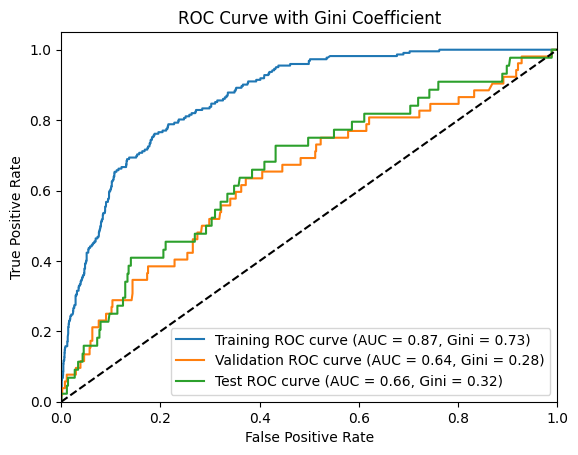

In [5]:
# Change the directory to the specified path
path = "../../2. Python/Finished Models"
os.chdir(path)

# Load the model and optimal features
xgb_model = joblib.load('xgb_model_1.pkl')
optimal_features = joblib.load('optimal_featuresxgb_model_1.pkl')

forforsta = df[['Ever90']+list(optimal_features)]

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Plot for both the training and validation sets
xgb_score = plot_gini(xgb_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")




In [6]:
optimal_features

array(['avg_Loan', 'avg_Salary', 'avg3Months_CashWithdrawal',
       'avg3Months_Deposit', 'avg3Months_Loan', 'avg6Months_Loan',
       'avg6Months_MobilePayment', 'avg6Months_Salary',
       'count_InstallmentPayment', 'count_Loan', 'sum_Salary',
       'trend_Gaming', 'trend_MobilePayment', 'Gambling_monthlyAvg',
       'CashWithdrawal_sum12Months', 'CashWithdrawal_sum6Months',
       'CashWithdrawal_sum9Months', 'Gaming_count3Months',
       'MobilePayment_partOfSalary3Months',
       'MobilePayment_partOfSalary6Months',
       'DebtCollection_partOfSalary9Months', 'DebtCollection_sum12Months',
       'InstallmentPayment_count12Months',
       'InstallmentPayment_monthlyAvg',
       'InstallmentPayment_partOfSalary12Months',
       'HousingCost_count6Months', 'HousingCost_partOfSalary3Months',
       'DirectDebit_sum12Months', 'Unclassified_count12Months',
       'Unclassified_sum3Months'], dtype='<U39')

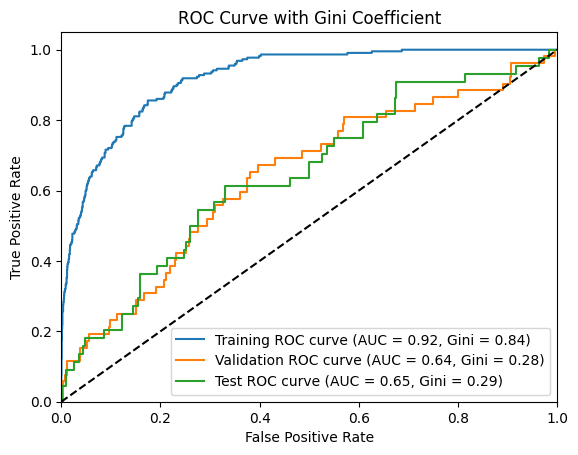

In [7]:


# Load the model and optimal features
rf_model = joblib.load('rf_model_1.pkl')
optimal_features = joblib.load('optimal_features_rf_model_1.pkl')

forforsta = df[['Ever90']+list(optimal_features)]

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Plot for both the training and validation sets
rf_score = plot_gini(rf_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")





In [8]:
optimal_features

array(['avg6Months_Loan', 'avg_Loan', 'sum_Loan',
       'Unclassified_sum3Months', 'count_Loan', 'avg6Months_Salary',
       'avg_Salary', 'sum installmentPayments', 'avg3Months_Loan',
       'avg3Months_CashWithdrawal', 'DebtCollection_sum3Months',
       'avg6Months_CashWithdrawal', 'trend_Gaming', 'avg3Months_Deposit',
       'Gambling_sum9Months', 'InstallmentPayment_partOfSalary3Months',
       'trend_DebtCollection', 'DebtCollection_sum12Months',
       'CashWithdrawal_sum6Months', 'Gaming_count3Months',
       'trend_Deposit', 'CashWithdrawal_partOfSalary9Months',
       'count_MobilePayment', 'InstallmentPayment_partOfSalary6Months',
       'DebtCollection_sum9Months', 'sum_Gambling', 'avg_Gambling',
       'sum_Salary', 'trend_Salary', 'Gaming_partOfSalary12Months',
       'CashWithdrawal_partOfSalary3Months', 'Gaming_count6Months',
       'avg3Months_MobilePayment', 'MobilePayment_count12Months',
       'HousingCost_category', 'MobilePayment_partOfSalary6Months'],
      dtyp

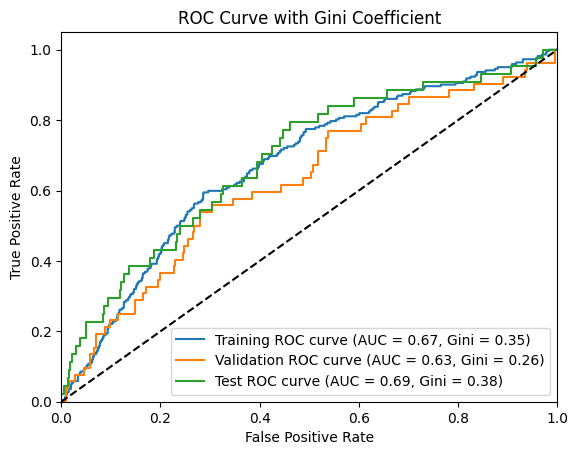

In [9]:


# Load the model and optimal features
lg_model = joblib.load('lg_model_1.pkl')
optimal_features = joblib.load('optimal_features_lg_model_1.pkl')

forforsta = df[['Ever90']+list(optimal_features)]

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Plot for both the training and validation sets
lg_score =  plot_gini(lg_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")




In [10]:
optimal_features

array(['avg_Loan', 'avg3Months_CashWithdrawal', 'avg3Months_Deposit',
       'avg3Months_Loan', 'avg3Months_Salary', 'avg6Months_Gambling',
       'count_Loan', 'sum_Salary', 'trend_Gaming', 'Gaming_count3Months',
       'InstallmentPayment_count12Months', 'DirectDebit_sum12Months',
       'count_PassiveIncome'], dtype='<U39')

## Controll - From the best RF where all data was included and no amipulation on main/co


In [11]:
scores = df[['Ever90','ApplicationID','HasCoapp']]

In [12]:
scores['lg_score'] = lg_score
scores['rf_score'] = rf_score
scores['xgb_score'] = xgb_score



In [13]:
scores

,Ever90,ApplicationID,HasCoapp,lg_score,rf_score,xgb_score
0,0,8513891,1,0.637466,0.412130,0.533706
1,0,8528123,1,0.380880,0.376075,0.375010
2,0,8621901,1,0.521006,0.510928,0.520986
3,0,8201314,1,0.427796,0.417763,0.478537
4,0,8420404,0,0.445150,0.331904,0.404928
...,...,...,...,...,...,...
481,0,8409647,0,0.574922,0.454165,0.442422
482,0,8614945,0,0.483461,0.533501,0.406000
483,0,8370396,0,0.437565,0.393675,0.442698
484,0,8649594,1,0.366699,0.310770,0.305119


In [14]:
train = scores.iloc[:len(Xtrain)]

print(len(Xval))
val = scores.iloc[len(Xtrain):len(Xval)+len(Xtrain)]

print(len(Xtest))
test = scores.iloc[len(Xval)+len(Xtrain):]

595
486


## Splitta på Position istället

In [15]:
# train = scores[scores.ApplicationID.isin(train.ApplicationID)].drop_duplicates()
# val = scores[scores.ApplicationID.isin(val.ApplicationID)].drop_duplicates()
# test = scores[scores.ApplicationID.isin(test.ApplicationID)].drop_duplicates()

In [16]:
df.drop_duplicates()

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-10-02,8409647,0,9501031414,2022-10-07,228000,1,1,0,0,...,100.0,100.0,694.6,282121.0,58860.0,141994,206258,0,0,0
482,2023-03-21,8614945,0,8409200352,2023-03-23,300000,1,1,0,0,...,187.1,516413.0,123722.0,324995.0,431425.0,0,0,0,0,0
483,2022-09-02,8370396,0,8803083602,2022-10-17,145000,1,1,0,0,...,106.7,318000.0,38583.0,133955.0,220786.0,0,0,0,0,0
484,2023-04-20,8649594,0,310031521,2023-04-24,285000,0,2,1,0,...,47050.0,235.6,119.1,260.5,237.3,623759,101160,415025,541105,0


In [17]:
print(len(train) + len(val) + len(test))

print(len(Xtrain) + len(Xval) + len(Xtest))

3453
3453


In [18]:





input = scores[['Ever90'] +['lg_score','rf_score',	'xgb_score'] ]

preprocessor = DataPreprocessor(input)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  ['lg_score','rf_score',	'xgb_score'])


In [19]:
input

,Ever90,lg_score,rf_score,xgb_score
0,0,0.637466,0.412130,0.533706
1,0,0.380880,0.376075,0.375010
2,0,0.521006,0.510928,0.520986
3,0,0.427796,0.417763,0.478537
4,0,0.445150,0.331904,0.404928
...,...,...,...,...
481,0,0.574922,0.454165,0.442422
482,0,0.483461,0.533501,0.406000
483,0,0.437565,0.393675,0.442698
484,0,0.366699,0.310770,0.305119


In [20]:
Xtrain

array([[ 1.36794079,  0.07263434,  0.85782585],
       [-0.74028337, -0.18944048, -0.45111847],
       [ 0.41105322,  0.79076792,  0.75290445],
       ...,
       [-0.37236947,  0.63701633,  0.44040271],
       [ 0.9701352 ,  1.78609955,  1.79736689],
       [-0.13947623, -0.56671848, -0.18830959]])

[I 2024-06-19 14:42:31,271] A new study created in memory with name: no-name-92c2192c-43f2-4111-8f7b-7212d5ba60d4
[I 2024-06-19 14:42:31,272] A new study created in memory with name: no-name-a378c111-081c-4562-b5d6-a33b1d0ed011
[I 2024-06-19 14:42:31,272] A new study created in memory with name: no-name-b5b94261-6f2e-4e55-b55c-41ed8441c57c
[I 2024-06-19 14:42:31,274] A new study created in memory with name: no-name-c20d08e5-f7e7-4d7f-bdaa-37da2dadc03d
[I 2024-06-19 14:42:31,335] Trial 0 finished with value: 0.8029203030196462 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.8029203030196462.
[I 2024-06-19 14:42:31,349] Trial 0 finished with value: 0.8621728072009739 and parameters: {'C': 0.005357227309157648, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8621728072009739.
[I 2024-06-19 14:42:31,374] Trial 1 finished with value: 0.6563915280372351 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.041865388038708984, 'binarize': 0.03649919165881475}. Best is t

Best parameters: {'naive_bayes': {}, 'xgboost': {'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.12021443646684667}, 'random_forest': {'n_estimators': 28, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3}, 'logistic_regression': {'C': 0.005626191951906475, 'solver': 'saga', 'penalty_saga': None}}


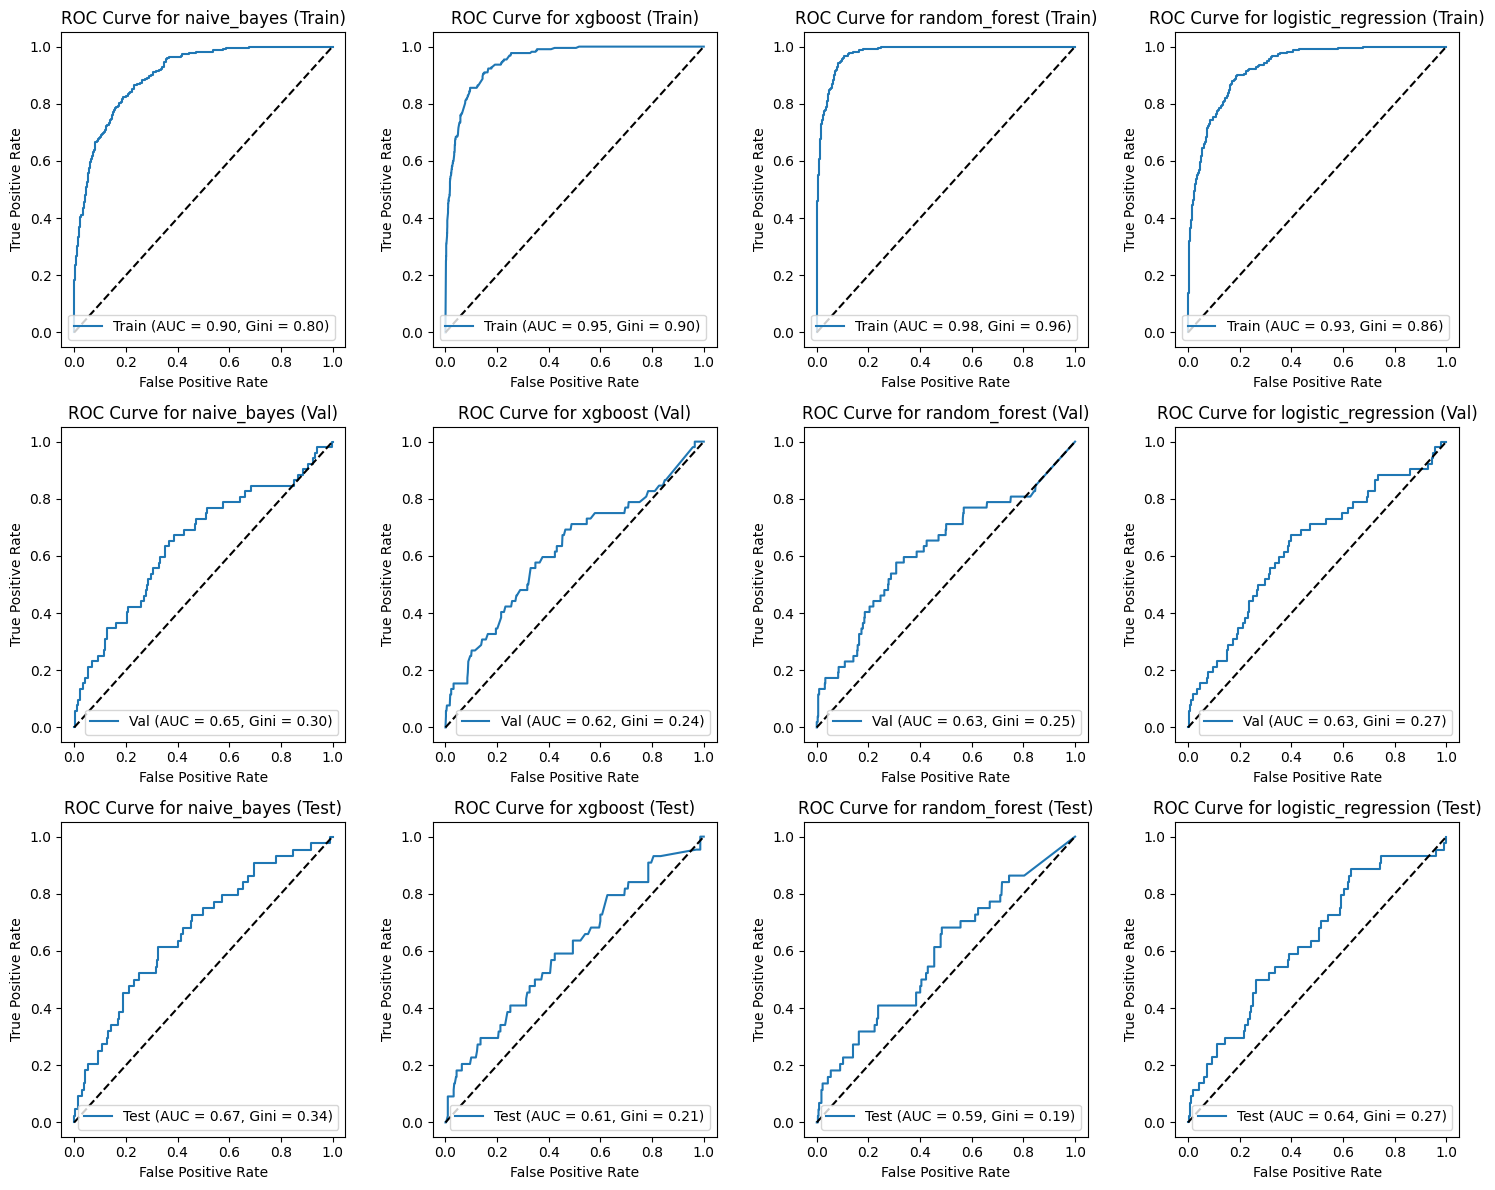

Available steps in pipeline: {'upsample': SMOTE(), 'model': RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=28)}
Available steps in pipeline: {'upsample': SMOTE(), 'model': LogisticRegression(C=0.005626191951906475, max_iter=10000, solver='saga')}
Available steps in pipeline: {'upsample': SMOTE(), 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12021443646684667, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing

Non-zero features: ['rf_score', 'xgb_score', 'lg_score']


In [21]:


models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models, Xtrain, Ytrain, n_trials=iterations, early_stopping_rounds=10)
best_params, best_models = optimizer.run_models()
print("Best parameters:", best_params)

evaluator = ModelEvaluator(Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()

feature_importance = FeatureImportance(input, best_models, run_correlation_cluster=True)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features, non_zero_features = feature_importance.plot_importances()

# Filter away highly correlated features and take away the absolute worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
SelectionOne = filtered_list[:40]

print("Non-zero features:", non_zero_features)


In [22]:
best_models['naive_bayes']              ## .predict_log_proba(Xtrain)

Pipeline(steps=[('upsample', SMOTE()), ('model', GaussianNB())])

In [23]:
import joblib

path = "../../2. Python/Finished Models"
os.chdir(path)


# Save the model and features
joblib.dump(best_models['naive_bayes'] , os.path.join( 'naive_bayes_model_2.pkl'))

joblib.dump(non_zero_features, os.path.join('optimal_features_naive_bayes_model_2.pkl'))

print("Model and features have been saved to Python/Finished Models.")

Model and features have been saved to Python/Finished Models.


## Try DL

In [24]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import torch
from torch import nn
from torch.optim import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Custom Torch Classifier
class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, lr=0.001, weight_decay=0.0005, dropout_rate=0.6, num_epochs=5):
        self.input_dim = input_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.num_epochs = num_epochs
        self.model = self._build_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        return model

    def fit(self, X, y):
        self.model.train()
        criterion = nn.BCELoss()
        optimizer = Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        for epoch in range(self.num_epochs):
            for data in loader:
                inputs, labels = data
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
        return outputs.numpy()

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

# Custom gini scorer
def gini_scorer(y_true, y_pred_proba):
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_true, y_pred_proba)
    return 2 * auc - 1

# Plot ROC curve with Gini Coefficient
def plot_gini(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)
    y_val_pred_proba = model.predict_proba(X_val)
    y_test_pred_proba = model.predict_proba(X_test)

    fpr_train, tpr_train, _ = roc_curve(Y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(Y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(Y_test, y_test_pred_proba)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_auc_test = auc(fpr_test, tpr_test)

    gini_train = 2 * roc_auc_train - 1
    gini_val = 2 * roc_auc_val - 1
    gini_test = 2 * roc_auc_test - 1

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {roc_auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {roc_auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    

In [25]:

# # Hyperparameter tuning
# # param_grid = {
# #     'lr': [0.001 , 0.03 , 0.0001 , 0.0005, 0.00001],
# #     'weight_decay': [0.0005 ,0.05],
# #     'dropout_rate': [0.4,0.6] ,
# #     'num_epochs': [6,14,20]
# # }

# param_grid = {
#     'lr': [0.001, 0.003, 0.0008, 0.01, 0.005],
#     'weight_decay': [0.0005, 0.005, 0.001, 0.01],
#     'dropout_rate': [0.2, 0.4, 0.6, 0.5, 0.3],
#     'num_epochs': [3, 5, 7, 9, 12, 15, 20, 25]
# }

# grid_search = GridSearchCV(
#     estimator=TorchClassifier(input_dim=Xtrain.shape[1]),
#     param_grid=param_grid,
#     scoring=make_scorer(gini_scorer, needs_proba=True),
#     cv=3
# )

# grid_search.fit(Xtrain, Ytrain)

# best_params = grid_search.best_params_
# print("Best hyperparameters:", best_params)

# # Train best model
# best_model = TorchClassifier(input_dim=Xtrain.shape[1], **best_params)
# best_model.fit(Xtrain, Ytrain)

# # Evaluate model
# y_train_pred_proba = best_model.predict_proba(Xtrain)
# y_val_pred_proba = best_model.predict_proba(Xval)
# y_test_pred_proba = best_model.predict_proba(Xtest)

# gini_train = gini_scorer(Ytrain, y_train_pred_proba)
# gini_val = gini_scorer(Yval, y_val_pred_proba)
# gini_test = gini_scorer(Ytest, y_test_pred_proba)


# plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


## initals done

In [26]:
df

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-10-02,8409647,0,9501031414,2022-10-07,228000,1,1,0,0,...,100.0,100.0,694.6,282121.0,58860.0,141994,206258,0,0,0
482,2023-03-21,8614945,0,8409200352,2023-03-23,300000,1,1,0,0,...,187.1,516413.0,123722.0,324995.0,431425.0,0,0,0,0,0
483,2022-09-02,8370396,0,8803083602,2022-10-17,145000,1,1,0,0,...,106.7,318000.0,38583.0,133955.0,220786.0,0,0,0,0,0
484,2023-04-20,8649594,0,310031521,2023-04-24,285000,0,2,1,0,...,47050.0,235.6,119.1,260.5,237.3,623759,101160,415025,541105,0


In [27]:
ntr = list(best_models['naive_bayes'].predict_proba(Xtrain)[:, 1])
nta = list(best_models['naive_bayes'].predict_proba(Xval)[:, 1])
nte = list(best_models['naive_bayes'].predict_proba(Xtest)[:, 1])





In [28]:
input['Combo_2NB'] =  ntr + nta + nte
input['ApplicationID'] = df.ApplicationID
input

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
0,0,0.637466,0.412130,0.533706,0.365168,8513891
1,0,0.380880,0.376075,0.375010,0.003987,8528123
2,0,0.521006,0.510928,0.520986,0.679486,8621901
3,0,0.427796,0.417763,0.478537,0.089883,8201314
4,0,0.445150,0.331904,0.404928,0.003667,8420404
...,...,...,...,...,...,...
481,0,0.574922,0.454165,0.442422,0.180958,8409647
482,0,0.483461,0.533501,0.406000,0.250840,8614945
483,0,0.437565,0.393675,0.442698,0.030558,8370396
484,0,0.366699,0.310770,0.305119,0.000155,8649594


In [29]:
input[input.ApplicationID ==  8621901]

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
2,0,0.521006,0.510928,0.520986,0.679486,8621901
2327,0,0.404955,0.266434,0.305119,0.000061,8621901


## Combine Main & Co Score

In [30]:
import pandas as pd

# Assuming 'input' is your original DataFrame
df_predictions = input.copy()

# Group by 'ApplicationID' and get the minimum 'xgb_score' for each account
min_probabilities = df_predictions.groupby('ApplicationID')['xgb_score'].min().reset_index()
min_probabilities.rename(columns={'xgb_score': 'min_xgb_score'}, inplace=True)

# Group by 'ApplicationID' and get the maximum 'xgb_score' for each account
max_probabilities = df_predictions.groupby('ApplicationID')['xgb_score'].max().reset_index()
max_probabilities.rename(columns={'xgb_score': 'max_xgb_score'}, inplace=True)

# Merge the original DataFrame with min and max probabilities
df_merged = df_predictions.merge(min_probabilities, on='ApplicationID')
df_merged = df_merged.merge(max_probabilities, on='ApplicationID')

# If you want to drop duplicates based on specific columns (e.g., 'ApplicationID'), you can do:
df_merged.drop_duplicates(subset=['ApplicationID'], inplace=True)




In [31]:
df_merged

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID,min_xgb_score,max_xgb_score
0,0,0.637466,0.412130,0.533706,0.365168,8513891,0.533706,0.563262
1,0,0.380880,0.376075,0.375010,0.003987,8528123,0.375010,0.630736
2,0,0.521006,0.510928,0.520986,0.679486,8621901,0.305119,0.520986
3,0,0.427796,0.417763,0.478537,0.089883,8201314,0.371481,0.478537
4,0,0.445150,0.331904,0.404928,0.003667,8420404,0.404928,0.404928
...,...,...,...,...,...,...,...,...
3447,0,0.379285,0.264083,0.445917,0.001108,8466300,0.445917,0.445917
3448,0,0.574922,0.454165,0.442422,0.180958,8409647,0.442422,0.442422
3449,0,0.483461,0.533501,0.406000,0.250840,8614945,0.406000,0.406000
3450,0,0.437565,0.393675,0.442698,0.030558,8370396,0.442698,0.442698


## Test Min Score

In [32]:


train = df_merged[df_merged.ApplicationID.isin(train.ApplicationID)].drop_duplicates()
val = df_merged[df_merged.ApplicationID.isin(val.ApplicationID)].drop_duplicates()
test = df_merged[df_merged.ApplicationID.isin(test.ApplicationID)].drop_duplicates()



In [33]:
set(train.ApplicationID)

len(set(df_merged.ApplicationID))

2987

In [34]:
min_train = pd.merge(df_merged, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
min_val = pd.merge(df_merged, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
min_test = pd.merge(df_merged, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()

In [35]:

y_train_pred_proba = min_train.min_xgb_score
y_train =  min_train.Ever90

y_val_pred_proba = min_val.min_xgb_score
y_val =  min_val.Ever90

y_test_pred_proba = min_test.min_xgb_score
y_test =  min_test.Ever90

    # Function to plot Gini coefficient
def plot_gini( y_train_pred_proba, y_train, y_val_pred_proba, y_val, y_test_pred_proba, y_test, title):

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    return np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])




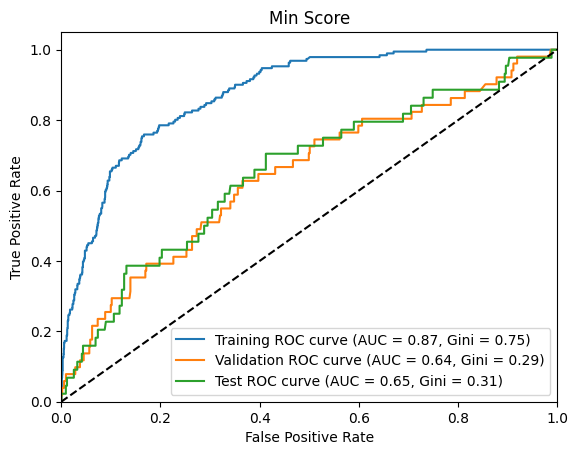

array([0.5337065 , 0.37500966, 0.305119  , ..., 0.40599984, 0.44269767,
       0.53324974], dtype=float32)

In [36]:
plot_gini( y_train_pred_proba, y_train, y_val_pred_proba, y_val, y_test_pred_proba, y_test, 'Min Score')

## max Score

In [37]:
max_train = pd.merge(df_merged, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
max_val = pd.merge(df_merged, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
max_test = pd.merge(df_merged, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()




y_train_pred_proba = max_train.max_xgb_score
y_train =  max_train.Ever90

y_val_pred_proba = max_val.max_xgb_score
y_val =  max_val.Ever90

y_test_pred_proba = max_test.max_xgb_score
y_test =  max_test.Ever90


In [38]:
df_merged

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID,min_xgb_score,max_xgb_score
0,0,0.637466,0.412130,0.533706,0.365168,8513891,0.533706,0.563262
1,0,0.380880,0.376075,0.375010,0.003987,8528123,0.375010,0.630736
2,0,0.521006,0.510928,0.520986,0.679486,8621901,0.305119,0.520986
3,0,0.427796,0.417763,0.478537,0.089883,8201314,0.371481,0.478537
4,0,0.445150,0.331904,0.404928,0.003667,8420404,0.404928,0.404928
...,...,...,...,...,...,...,...,...
3447,0,0.379285,0.264083,0.445917,0.001108,8466300,0.445917,0.445917
3448,0,0.574922,0.454165,0.442422,0.180958,8409647,0.442422,0.442422
3449,0,0.483461,0.533501,0.406000,0.250840,8614945,0.406000,0.406000
3450,0,0.437565,0.393675,0.442698,0.030558,8370396,0.442698,0.442698


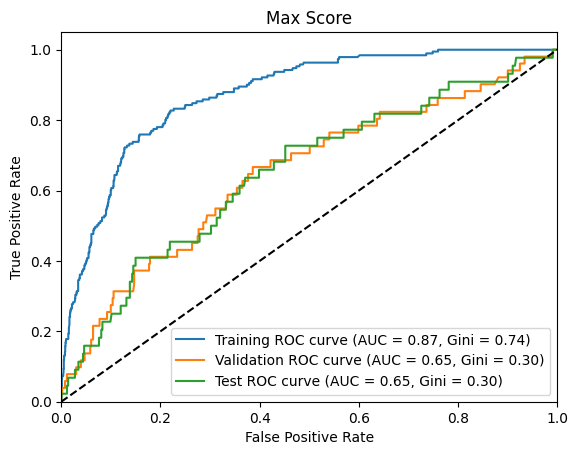

array([0.5632616 , 0.6307356 , 0.5209858 , ..., 0.40599984, 0.44269767,
       0.53324974], dtype=float32)

In [39]:
plot_gini( y_train_pred_proba, y_train, y_val_pred_proba, y_val, y_test_pred_proba, y_test, 'Max Score')

## Both 

In [40]:
input[input.ApplicationID ==  8621901]

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
2,0,0.521006,0.510928,0.520986,0.679486,8621901
2327,0,0.404955,0.266434,0.305119,0.000061,8621901


In [41]:
df[df.ApplicationID ==  8621901 ]

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
2327,2023-03-28,8621901,0,6607080287,2023-05-19,370000,1,1,1,0,...,44005.0,193.8,86.2,131.4,148.9,526808,57470,200072,313966,0


In [42]:
df_merged

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID,min_xgb_score,max_xgb_score
0,0,0.637466,0.412130,0.533706,0.365168,8513891,0.533706,0.563262
1,0,0.380880,0.376075,0.375010,0.003987,8528123,0.375010,0.630736
2,0,0.521006,0.510928,0.520986,0.679486,8621901,0.305119,0.520986
3,0,0.427796,0.417763,0.478537,0.089883,8201314,0.371481,0.478537
4,0,0.445150,0.331904,0.404928,0.003667,8420404,0.404928,0.404928
...,...,...,...,...,...,...,...,...
3447,0,0.379285,0.264083,0.445917,0.001108,8466300,0.445917,0.445917
3448,0,0.574922,0.454165,0.442422,0.180958,8409647,0.442422,0.442422
3449,0,0.483461,0.533501,0.406000,0.250840,8614945,0.406000,0.406000
3450,0,0.437565,0.393675,0.442698,0.030558,8370396,0.442698,0.442698


In [43]:
tsm = df_merged[['Ever90']]

tsm['min'] = df_merged.min_xgb_score
tsm['max'] = df_merged.max_xgb_score
tsm['ApplicationID'] = df_merged.ApplicationID



tsm

,Ever90,min,max,ApplicationID
0,0,0.533706,0.563262,8513891
1,0,0.375010,0.630736,8528123
2,0,0.305119,0.520986,8621901
3,0,0.371481,0.478537,8201314
4,0,0.404928,0.404928,8420404
...,...,...,...,...
3447,0,0.445917,0.445917,8466300
3448,0,0.442422,0.442422,8409647
3449,0,0.406000,0.406000,8614945
3450,0,0.442698,0.442698,8370396


In [44]:
tsm[tsm.ApplicationID ==  8621901]


,Ever90,min,max,ApplicationID
2,0,0.305119,0.520986,8621901


In [45]:
apli = df[['ApplicationID','HasCoapp']].drop_duplicates()

both = pd.merge(tsm,apli , on='ApplicationID')
both['maxadj'] = np.where(both.HasCoapp == 0 , np.mean(both[both.HasCoapp == 1]['max']) , both['max']) 



In [46]:
#  or (both['max'] == both['min'])

In [47]:
both

,Ever90,min,max,ApplicationID,HasCoapp,maxadj
0,0,0.533706,0.563262,8513891,1,0.563262
1,0,0.375010,0.630736,8528123,1,0.630736
2,0,0.305119,0.520986,8621901,1,0.520986
3,0,0.371481,0.478537,8201314,1,0.478537
4,0,0.404928,0.404928,8420404,0,0.444417
...,...,...,...,...,...,...
2982,0,0.445917,0.445917,8466300,1,0.445917
2983,0,0.442422,0.442422,8409647,0,0.444417
2984,0,0.406000,0.406000,8614945,0,0.444417
2985,0,0.442698,0.442698,8370396,0,0.444417


In [48]:
inpboth = both[['Ever90','min','maxadj']]
inpboth

,Ever90,min,maxadj
0,0,0.533706,0.563262
1,0,0.375010,0.630736
2,0,0.305119,0.520986
3,0,0.371481,0.478537
4,0,0.404928,0.444417
...,...,...,...
2982,0,0.445917,0.445917
2983,0,0.442422,0.444417
2984,0,0.406000,0.444417
2985,0,0.442698,0.444417


In [49]:
np.mean(both[both.HasCoapp == 1]['max'])


0.44441706

In [50]:
np.mean(both[both.HasCoapp == 1]['min'])

0.3749449

In [51]:
#tsm = df_merged

include_coapp = df[['ApplicationID','HasCoapp']].drop_duplicates()

df_merged = df_merged[['Ever90','ApplicationID','min_xgb_score','max_xgb_score']]

tsm =pd.merge(df_merged,include_coapp ,on='ApplicationID')

tsm['max_xgb_score'] = np.where(tsm.HasCoapp == 1 ,tsm['max_xgb_score'] ,np.mean(tsm[tsm.HasCoapp == 1].max_xgb_score) )

In [52]:
tsm

,Ever90,ApplicationID,min_xgb_score,max_xgb_score,HasCoapp
0,0,8513891,0.533706,0.563262,1
1,0,8528123,0.375010,0.630736,1
2,0,8621901,0.305119,0.520986,1
3,0,8201314,0.371481,0.478537,1
4,0,8420404,0.404928,0.444417,0
...,...,...,...,...,...
2982,0,8466300,0.445917,0.445917,1
2983,0,8409647,0.442422,0.444417,0
2984,0,8614945,0.406000,0.444417,0
2985,0,8370396,0.442698,0.444417,0


In [53]:
np.mean(tsm[tsm.HasCoapp == 1].min_xgb_score)

0.3749449

In [54]:
np.mean(tsm[tsm.HasCoapp == 1].max_xgb_score)

0.44441706

In [55]:
tsm_train = pd.merge(tsm, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_val = pd.merge(tsm, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_test = pd.merge(tsm, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()


In [56]:
tsm_train

,Ever90,ApplicationID,min_xgb_score,max_xgb_score,HasCoapp
0,0,8513891,0.533706,0.563262,1
1,0,8528123,0.375010,0.630736,1
2,0,8621901,0.305119,0.520986,1
3,0,8201314,0.371481,0.478537,1
4,0,8420404,0.404928,0.444417,0
...,...,...,...,...,...
1950,0,8516914,0.355339,0.454343,1
1951,0,8371422,0.205899,0.205899,1
1952,0,8488108,0.403439,0.444417,0
1953,0,8553015,0.446762,0.444417,0


In [57]:
forforsta = tsm_train

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(tsm_train,tsm_val, tsm_test, features =  ['min_xgb_score',	'max_xgb_score'])

In [58]:
forforsta[['Ever90','min_xgb_score','max_xgb_score']]

,Ever90,min_xgb_score,max_xgb_score
0,0,0.533706,0.563262
1,0,0.375010,0.630736
2,0,0.305119,0.520986
3,0,0.371481,0.478537
4,0,0.404928,0.444417
...,...,...,...
1950,0,0.355339,0.454343
1951,0,0.205899,0.205899
1952,0,0.403439,0.444417
1953,0,0.446762,0.444417


[I 2024-06-19 14:43:46,828] A new study created in memory with name: no-name-4aa391af-195a-4e0b-8336-b5ca2bd2fb8c
[I 2024-06-19 14:43:46,829] A new study created in memory with name: no-name-a265cfd6-a545-4df6-addf-474f4fa3dadb
[I 2024-06-19 14:43:46,829] A new study created in memory with name: no-name-3583a1db-ec28-416b-a29a-e64059f0c8ec
[I 2024-06-19 14:43:46,830] A new study created in memory with name: no-name-0aa7d9e4-a7e0-4f34-bbdc-37846d20da36
[I 2024-06-19 14:43:46,889] Trial 0 finished with value: 0.7591037572436382 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.7591037572436382.
[I 2024-06-19 14:43:46,894] Trial 0 finished with value: 0.7610786047223123 and parameters: {'C': 2.4846421692065435, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 0 with value: 0.7610786047223123.
[I 2024-06-19 14:43:46,934] Trial 1 finished with value: 0.5536898125652379 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.0044658465564252955, 'binarize': 0

Best parameters: {'naive_bayes': {}, 'xgboost': {'n_estimators': 32, 'max_depth': 3, 'learning_rate': 0.15457486827151012}, 'random_forest': {'n_estimators': 32, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1}, 'logistic_regression': {'C': 7.4354125544184795, 'solver': 'lbfgs'}}


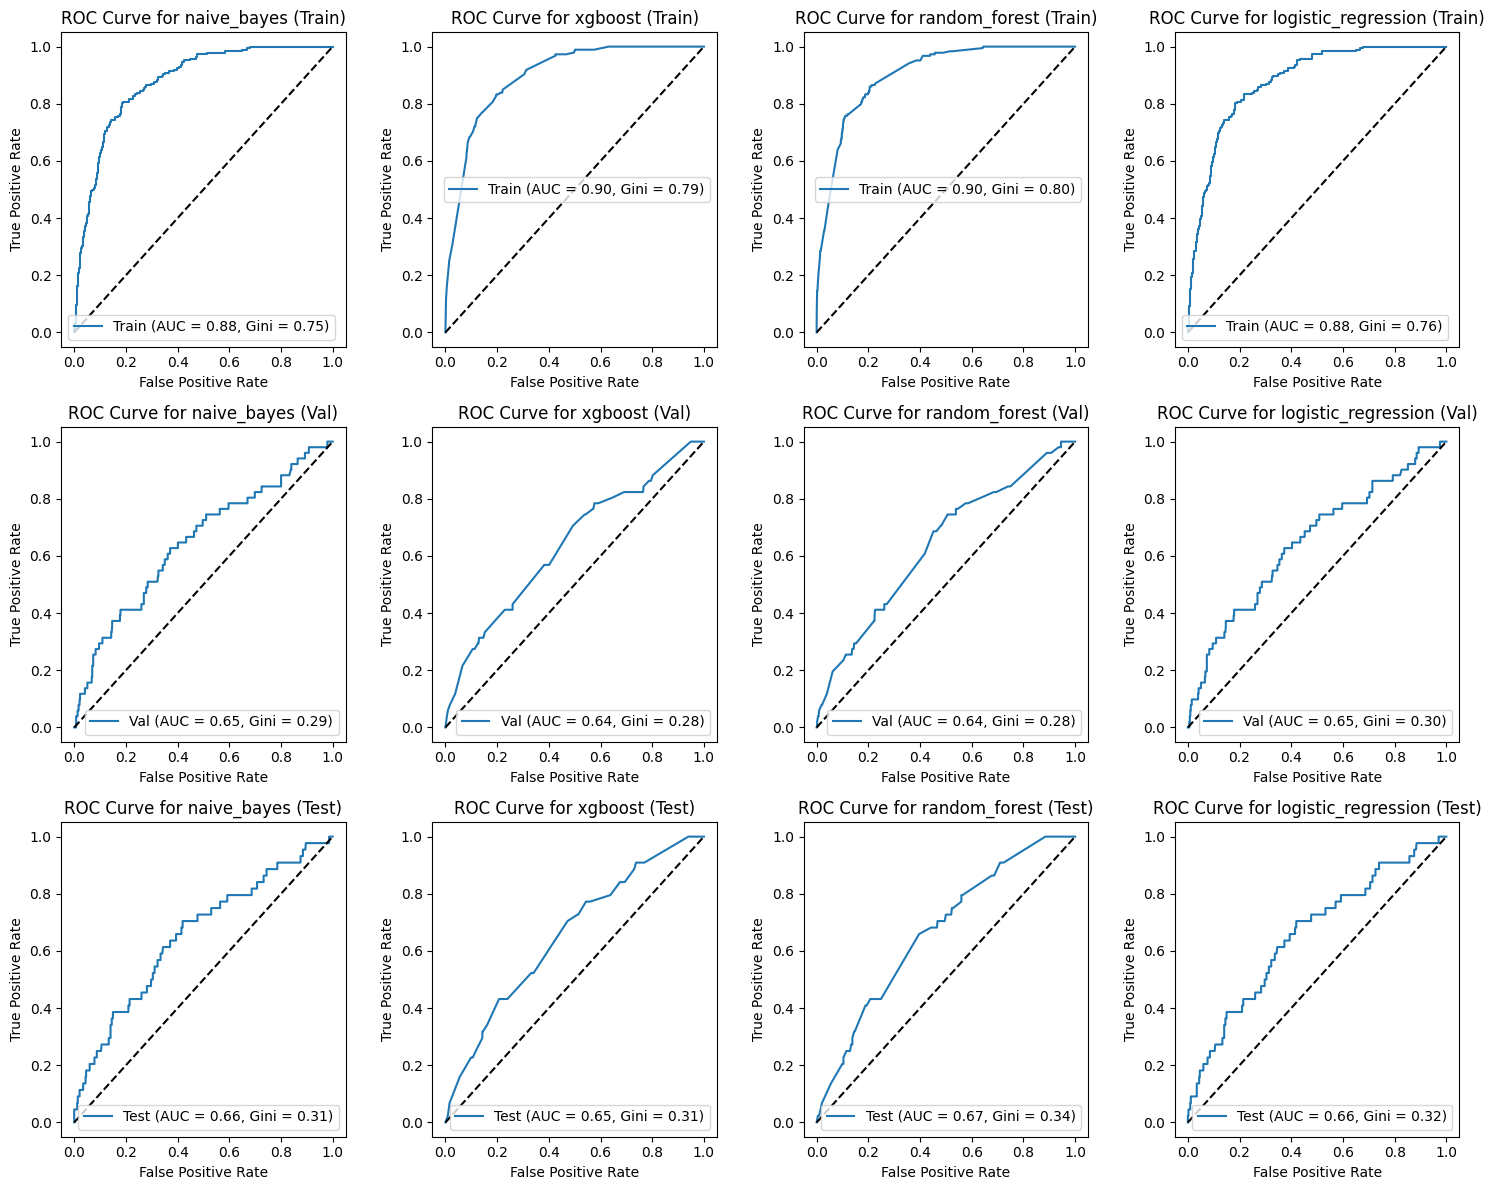

Available steps in pipeline: {'upsample': SMOTE(), 'model': RandomForestClassifier(max_depth=4, min_samples_split=3, n_estimators=32)}
Available steps in pipeline: {'upsample': SMOTE(), 'model': LogisticRegression(C=7.4354125544184795, max_iter=10000)}
Available steps in pipeline: {'upsample': SMOTE(), 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.15457486827151012, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strateg

Non-zero features: ['min_xgb_score', 'max_xgb_score']


In [59]:


models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models, Xtrain, Ytrain, n_trials=iterations, early_stopping_rounds=10)
best_params, best_models = optimizer.run_models()
print("Best parameters:", best_params)

evaluator = ModelEvaluator(Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()

feature_importance = FeatureImportance(forforsta[['Ever90','min_xgb_score','max_xgb_score']], best_models, run_correlation_cluster=True)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features, non_zero_features = feature_importance.plot_importances()

# Filter away highly correlated features and take away the absolute worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
SelectionOne = filtered_list[:40]

print("Non-zero features:", non_zero_features)


## With combination

In [60]:
import pandas as pd

# Assuming 'input' is your original DataFrame
df_predictions = input.copy()

# Group by 'ApplicationID' and get the minimum 'xgb_score' for each account
min_probabilities = df_predictions.groupby('ApplicationID')['Combo_2NB'].min().reset_index()
min_probabilities.rename(columns={'Combo_2NB': 'min_Combo_2NB_score'}, inplace=True)

# Group by 'ApplicationID' and get the maximum 'xgb_score' for each account
max_probabilities = df_predictions.groupby('ApplicationID')['Combo_2NB'].max().reset_index()
max_probabilities.rename(columns={'Combo_2NB': 'max_Combo_2NB_score'}, inplace=True)

# Merge the original DataFrame with min and max probabilities
df_merged = df_predictions.merge(min_probabilities, on='ApplicationID')
df_merged = df_merged.merge(max_probabilities, on='ApplicationID')

# If you want to drop duplicates based on specific columns (e.g., 'ApplicationID'), you can do:
df_merged.drop_duplicates(subset=['ApplicationID'], inplace=True)




In [61]:
df_merged

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score
0,0,0.637466,0.412130,0.533706,0.365168,8513891,0.365168,0.981544
1,0,0.380880,0.376075,0.375010,0.003987,8528123,0.003987,0.986404
2,0,0.521006,0.510928,0.520986,0.679486,8621901,0.000061,0.679486
3,0,0.427796,0.417763,0.478537,0.089883,8201314,0.000735,0.089883
4,0,0.445150,0.331904,0.404928,0.003667,8420404,0.003667,0.003667
...,...,...,...,...,...,...,...,...
3447,0,0.379285,0.264083,0.445917,0.001108,8466300,0.001108,0.001108
3448,0,0.574922,0.454165,0.442422,0.180958,8409647,0.180958,0.180958
3449,0,0.483461,0.533501,0.406000,0.250840,8614945,0.250840,0.250840
3450,0,0.437565,0.393675,0.442698,0.030558,8370396,0.030558,0.030558


In [62]:
#tsm = df_merged

include_coapp = df[['ApplicationID','HasCoapp']].drop_duplicates()

df_merged = df_merged[['Ever90','ApplicationID','min_Combo_2NB_score','max_Combo_2NB_score']]

tsm =pd.merge(df_merged,include_coapp ,on='ApplicationID')

tsm['max_Combo_2NB_score'] = np.where(tsm.HasCoapp == 1 ,tsm['max_Combo_2NB_score'] ,np.mean(tsm[tsm.HasCoapp == 1].max_Combo_2NB_score) )

tsm_train = pd.merge(tsm, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_val = pd.merge(tsm, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_test = pd.merge(tsm, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()


In [63]:
tsm_train

,Ever90,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score,HasCoapp
0,0,8513891,3.651681e-01,9.815442e-01,1
1,0,8528123,3.986606e-03,9.864039e-01,1
2,0,8621901,6.135206e-05,6.794856e-01,1
3,0,8201314,7.348497e-04,8.988312e-02,1
4,0,8420404,3.667475e-03,2.658505e-01,0
...,...,...,...,...,...
1950,0,8516914,4.307212e-02,1.338454e-01,1
1951,0,8371422,1.638153e-08,1.638153e-08,1
1952,0,8488108,1.693002e-01,2.658505e-01,0
1953,0,8553015,2.180887e-02,2.658505e-01,0


[I 2024-06-19 14:44:53,353] A new study created in memory with name: no-name-e86ff718-03ea-4b36-a93d-d6f3700fed01
[I 2024-06-19 14:44:53,354] A new study created in memory with name: no-name-30920d9f-8374-4f19-9ec2-c3a150ca9b10
[I 2024-06-19 14:44:53,354] A new study created in memory with name: no-name-c2e7e817-98ed-44b2-a69f-3d1a04b70534
[I 2024-06-19 14:44:53,354] A new study created in memory with name: no-name-ee8332cd-ff34-40d5-abe3-ac4bf9f1950b
[I 2024-06-19 14:44:53,410] Trial 0 finished with value: 0.809640787531944 and parameters: {'C': 0.001716545953041408, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 0 with value: 0.809640787531944.
[I 2024-06-19 14:44:53,411] Trial 0 finished with value: 0.8138823651153583 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.8138823651153583.
[I 2024-06-19 14:44:53,448] Trial 1 finished with value: 0.8125160282366913 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.813882365115358

Best parameters: {'naive_bayes': {}, 'xgboost': {'n_estimators': 23, 'max_depth': 3, 'learning_rate': 0.14498988736802143}, 'random_forest': {'n_estimators': 31, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}, 'logistic_regression': {'C': 0.001716545953041408, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}}


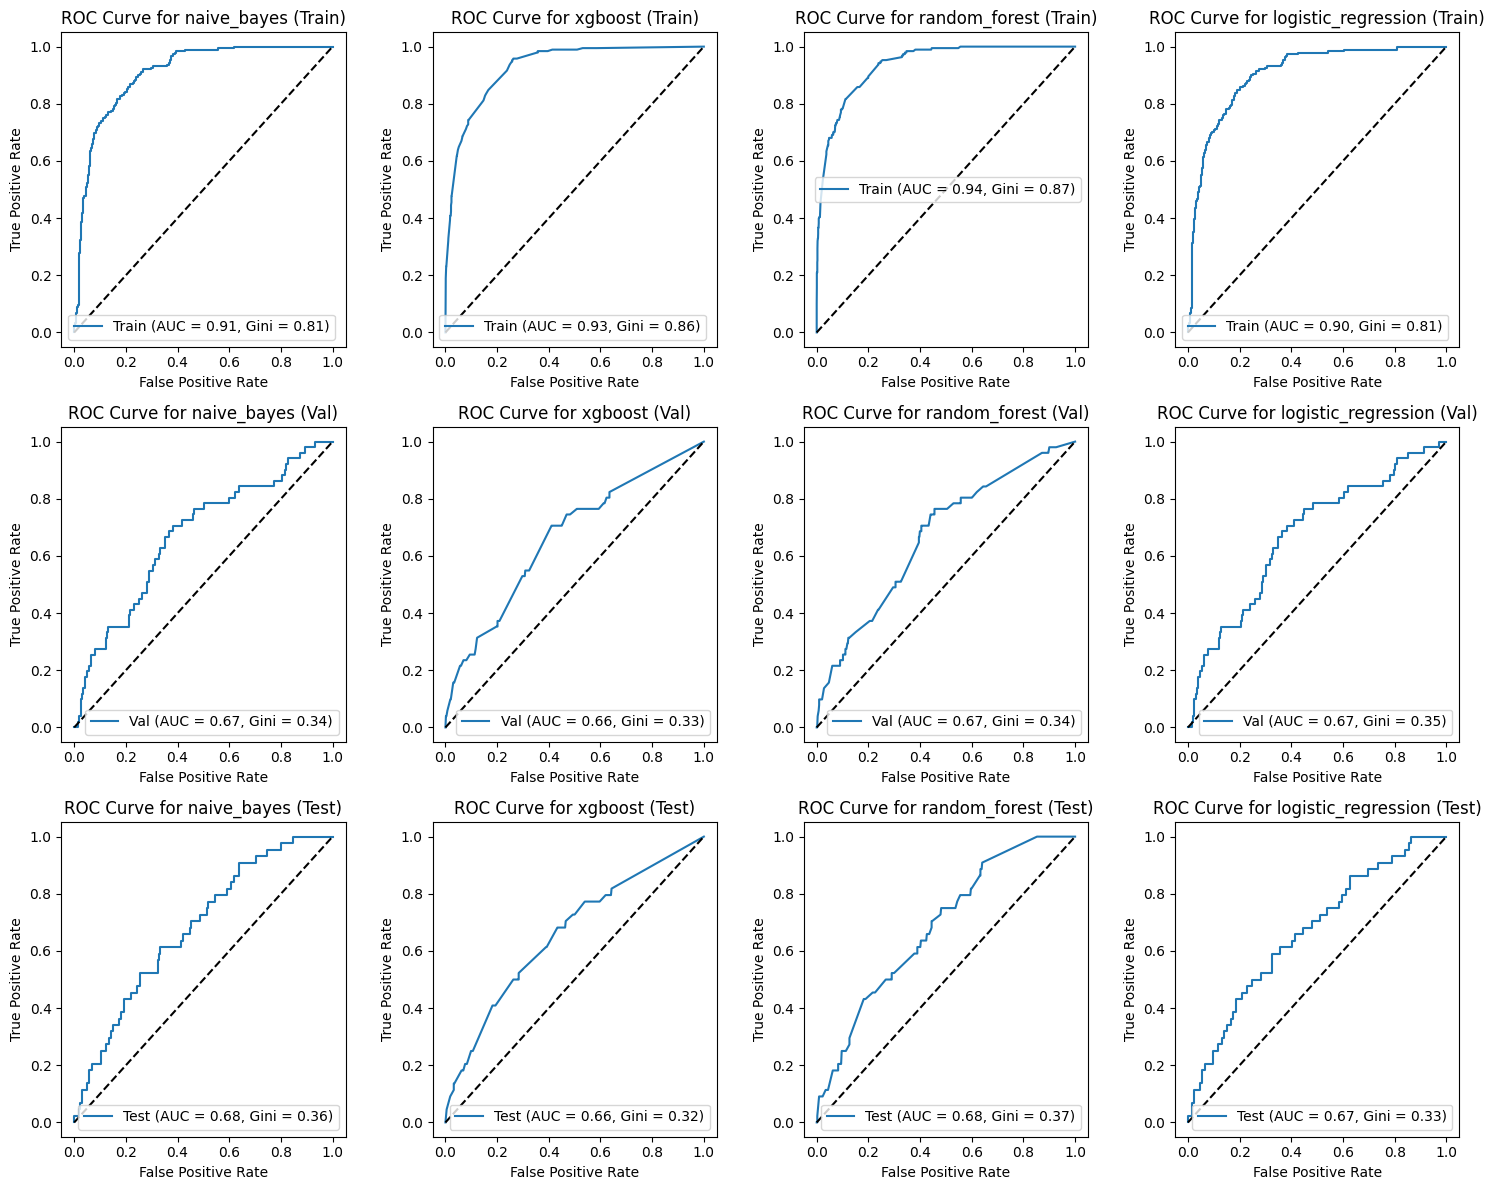

Available steps in pipeline: {'upsample': SMOTE(), 'model': RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=3,
                       n_estimators=31)}
Available steps in pipeline: {'upsample': SMOTE(), 'model': LogisticRegression(C=0.001716545953041408, max_iter=10000, solver='liblinear')}
Available steps in pipeline: {'upsample': SMOTE(), 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.14498988736802143, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, mi

Non-zero features: ['min_Combo_2NB_score', 'max_Combo_2NB_score']


In [65]:
forforsta = tsm_train

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(tsm_train,tsm_val, tsm_test, features =  ['min_Combo_2NB_score',	'max_Combo_2NB_score'])



models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models, Xtrain, Ytrain, n_trials=iterations, early_stopping_rounds=10)
best_params, best_models = optimizer.run_models()
print("Best parameters:", best_params)

evaluator = ModelEvaluator(Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()

feature_importance = FeatureImportance(forforsta[['Ever90','min_Combo_2NB_score','max_Combo_2NB_score']], best_models, run_correlation_cluster=True)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features, non_zero_features = feature_importance.plot_importances()

# Filter away highly correlated features and take away the absolute worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
SelectionOne = filtered_list[:40]

print("Non-zero features:", non_zero_features)


In [66]:
# # import joblib

# # path = "../../2. Python/Finished Models"
# # os.chdir(path)


# Save the model and features
joblib.dump(best_models['random_forest'] , os.path.join( 'random_forest_model_3.pkl'))

#joblib.dump(non_zero_features, os.path.join('optimal_features_naive_bayes_model_2.pkl'))

print("Model and features have been saved to Python/Finished Models.")


Model and features have been saved to Python/Finished Models.
